**Library Importing**

In [343]:
import time
import pandas_datareader as pdr
import numpy as np
import pandas as pd
import keras
from keras.layers import LSTM, TimeDistributed, Dense, Activation, Dropout
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import plotly.graph_objs as go
import plotly.express as px

**Dataset Loading**

In [344]:
dataframe = pd.read_csv("/content/yahoo_stock.csv")
dataframe.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [345]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1825 non-null   object 
 1   High       1825 non-null   float64
 2   Low        1825 non-null   float64
 3   Open       1825 non-null   float64
 4   Close      1825 non-null   float64
 5   Volume     1825 non-null   float64
 6   Adj Close  1825 non-null   float64
dtypes: float64(6), object(1)
memory usage: 99.9+ KB


**Data Preprocessing**

In [346]:
dataframe["Date"] = pd.to_datetime(dataframe["Date"])

In [347]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1825 non-null   datetime64[ns]
 1   High       1825 non-null   float64       
 2   Low        1825 non-null   float64       
 3   Open       1825 non-null   float64       
 4   Close      1825 non-null   float64       
 5   Volume     1825 non-null   float64       
 6   Adj Close  1825 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 99.9 KB


In [348]:
dataframe["Date"].min(), dataframe["Date"].max()

(Timestamp('2015-11-23 00:00:00'), Timestamp('2020-11-20 00:00:00'))

In [349]:
dataframe.set_index("Date",inplace=True)
dataframe.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


**Data Visualisation**

In [350]:
trace_high = go.Scatter(x=dataframe.index, y=dataframe["High"], name="High")
trace_low = go.Scatter(x=dataframe.index, y=dataframe["Low"], name="Low")
trace_open = go.Scatter(x=dataframe.index, y=dataframe["Open"], name="Open")
trace_close = go.Scatter(x=dataframe.index, y=dataframe["Close"], name="Close")

data = [trace_high, trace_low, trace_open, trace_close]

layout = go.Layout(
    title="Plotting Price against the Entire Timeframe For all the columns",
    xaxis=dict(title="Time ---------------->"),
    yaxis=dict(title="Price ---------------->"),
    legend=dict(x=0, y=1, traceorder="normal"),
    autosize=False,
    width=1000,
    height=700,
)

fig = go.Figure(data=data, layout=layout)

fig.show()

In [351]:
fig = px.line(dataframe, x=dataframe.index, y="High", title="Plotting Price against the Entire Timeframe For HIGH column")
fig.update_xaxes(title_text="Time ---------------->")
fig.update_yaxes(title_text="Price ---------------->")

fig.show()

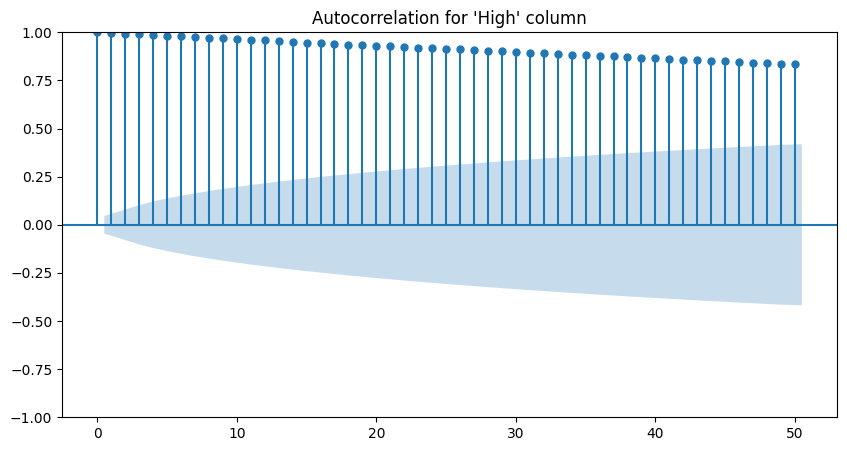

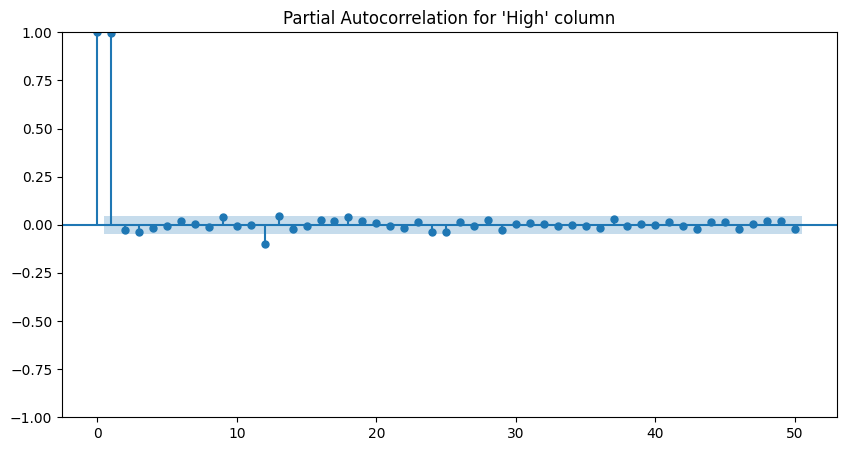

In [386]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot autocorrelation for the "High" column
plt.figure(figsize=(10, 5))
plot_acf(dataframe["High"], lags=50, ax=plt.gca())
plt.title("Autocorrelation for 'High' column")
plt.show()

# Plot partial autocorrelation for the "High" column
plt.figure(figsize=(10, 5))
plot_pacf(dataframe["High"], lags=50, ax=plt.gca())
plt.title("Partial Autocorrelation for 'High' column")
plt.show()


**Data Training**

In [352]:
new_df = pd.DataFrame(dataframe["High"].copy(), columns=["High"])
new_df.head()

,High
Date,
2015-11-23,2095.610107
2015-11-24,2094.120117
2015-11-25,2093.000000
2015-11-26,2093.000000
2015-11-27,2093.290039


In [353]:
train_size = int(len(new_df)*0.8)

train = new_df.iloc[0:train_size]
test = new_df.iloc[train_size:len(new_df)]

In [354]:
len(train), len(test)

(1460, 365)

**Feature Engineering**

In [355]:
def create_dataset(X, y, lag=1):
    xs,ys = [], []

    for i in range(len(X) - lag):
        tmp = X.iloc[i: i+lag].values
        xs.append(tmp)
        ys.append(y.iloc[i+lag])

    return np.array(xs), np.array(ys)

In [356]:
xtrain, ytrain = create_dataset(train, train["High"],10)
xtest, ytest = create_dataset(test, test["High"],10)

In [357]:
xtrain[0]

array([[2095.61010742],
       [2094.12011719],
       [2093.        ],
       [2093.        ],
       [2093.29003906],
       [2093.29003906],
       [2093.29003906],
       [2093.81005859],
       [2103.37011719],
       [2104.27001953]])

In [358]:
ytrain[0]

2085.0

In [359]:
xtrain.shape

(1450, 10, 1)

**LSTM Model**

In [381]:
model = Sequential()
model.add(LSTM(50,activation='relu', input_shape=(xtrain.shape[1], xtrain.shape[2])))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

In [361]:
model.fit(xtrain, ytrain,
         epochs=10,
         batch_size=10,
         verbose=1,
         shuffle=False
         )

Epoch 1/10
145/145 [==============================] - 2s 5ms/step - loss: 263425.7188
Epoch 2/10
145/145 [==============================] - 1s 4ms/step - loss: 786.2874
Epoch 3/10
145/145 [==============================] - 1s 4ms/step - loss: 903.1969
Epoch 4/10
145/145 [==============================] - 1s 5ms/step - loss: 1111.4192
Epoch 5/10
145/145 [==============================] - 1s 5ms/step - loss: 1009.4415
Epoch 6/10
145/145 [==============================] - 1s 4ms/step - loss: 1677.2361
Epoch 7/10
145/145 [==============================] - 1s 5ms/step - loss: 1053.4897
Epoch 8/10
145/145 [==============================] - 1s 5ms/step - loss: 1069.3837
Epoch 9/10
145/145 [==============================] - 1s 7ms/step - loss: 1085.9617
Epoch 10/10
145/145 [==============================] - 1s 7ms/step - loss: 1095.8274


In [362]:
ypred = model.predict(xtest)

12/12 [==============================] - 0s 3ms/step


Text(0.5, 1.0, 'Plotting Predicted And Actual Values Together against the Entire Timeframe')

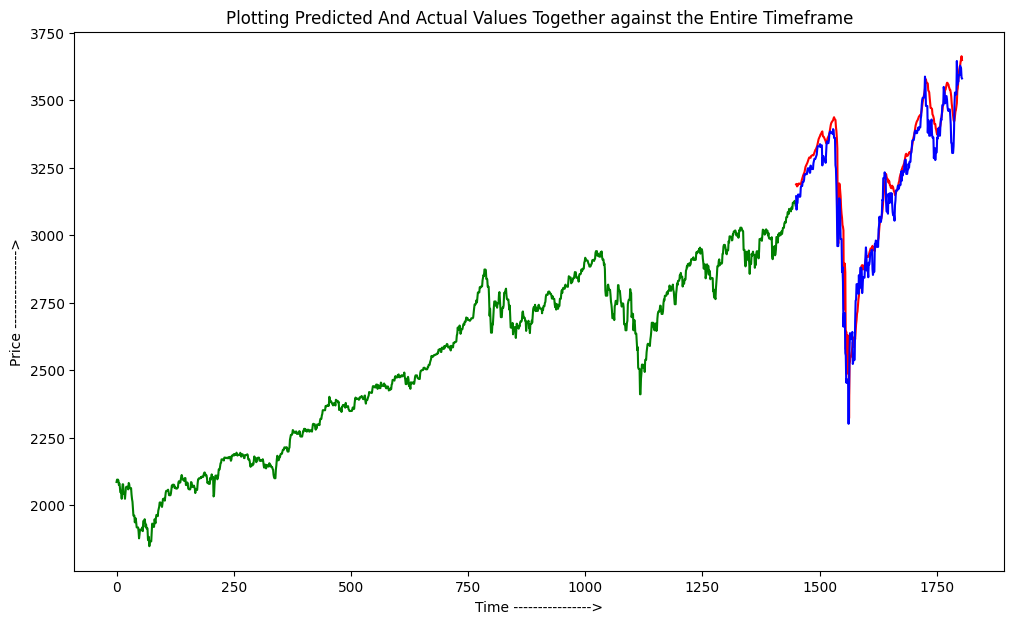

In [363]:
plt.figure(figsize=(12,7))
plt.plot(np.arange(0, len(xtrain)), ytrain, 'g', label="history")
plt.plot(np.arange(len(xtrain), len(xtrain) + len(xtest)), ypred, 'r', label="predictions")
plt.plot(np.arange(len(xtrain), len(xtrain) + len(xtest)), ytest, 'b', label="Actual")
plt.xlabel("Time ---------------->")
plt.ylabel("Price ---------------->")
plt.title("Plotting Predicted And Actual Values Together against the Entire Timeframe")

In [383]:
from sklearn.metrics import mean_squared_error
mean_squared_error(ytest, ypred)

338490.52108483564

In [385]:
rmse_lstm = mean_squared_error(ytest, ypred, squared=False)
print(f"RMSE for LSTM Model: {rmse_lstm}")

RMSE for LSTM Model: 581.7993821626452


Text(0.5, 1.0, 'Plotting Predicted And Actual Values Together against the Testing Timeframe')

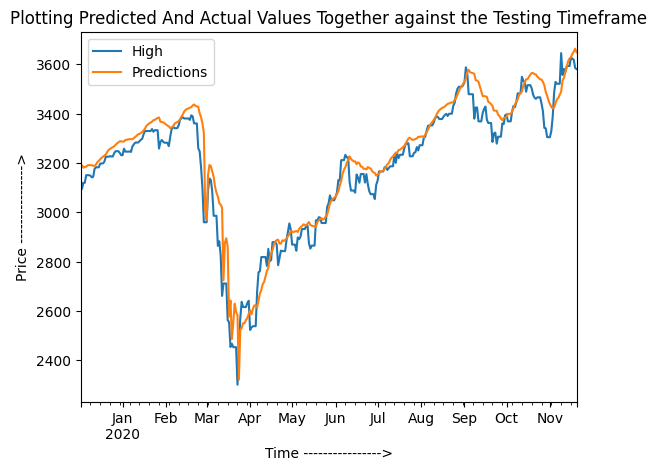

In [366]:
test = new_df.iloc[train_size+10:].copy()

test["Predictions"] = ypred
test[["High", "Predictions"]].plot()
plt.xlabel("Time ---------------->")
plt.ylabel("Price ---------------->")
plt.title("Plotting Predicted And Actual Values Together against the Testing Timeframe")

**Bidirectional LSTM Model**

In [367]:
model = Sequential()
model.add(LSTM(100, activation='relu',
               input_shape=(10, 1),
               return_sequences=True))
model.add(Dropout(0.2))

# hidden layer 2
model.add(LSTM(100,activation='relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

In [368]:
model.fit(xtrain, ytrain,
               epochs=20, batch_size=16,
               verbose=1,
               )

Epoch 1/20
91/91 [==============================] - 4s 15ms/step - loss: 1039372.6250
Epoch 2/20
91/91 [==============================] - 1s 15ms/step - loss: 309290.9375
Epoch 3/20
91/91 [==============================] - 2s 19ms/step - loss: 215405.6094
Epoch 4/20
91/91 [==============================] - 2s 25ms/step - loss: 198818.6250
Epoch 5/20
91/91 [==============================] - 1s 15ms/step - loss: 194600.7188
Epoch 6/20
91/91 [==============================] - 1s 15ms/step - loss: 165636.7812
Epoch 7/20
91/91 [==============================] - 1s 15ms/step - loss: 194747.4062
Epoch 8/20
91/91 [==============================] - 1s 15ms/step - loss: 145706.4844
Epoch 9/20
91/91 [==============================] - 1s 15ms/step - loss: 142429.0469
Epoch 10/20
91/91 [==============================] - 1s 15ms/step - loss: 127564.3672
Epoch 11/20
91/91 [==============================] - 1s 15ms/step - loss: 118685.3438
Epoch 12/20
91/91 [==============================] - 2s 22ms/s

In [369]:
ypred = model.predict(xtest)

12/12 [==============================] - 0s 7ms/step


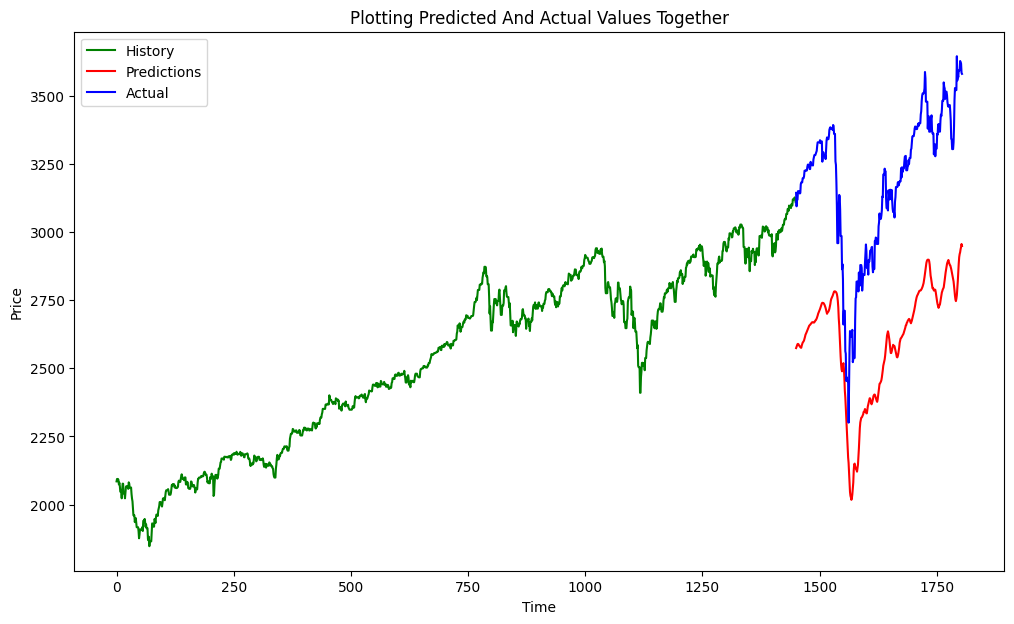

In [370]:
plt.figure(figsize=(12, 7))
plt.plot(np.arange(0, len(xtrain)), ytrain, 'g', label="History")
plt.plot(np.arange(len(xtrain), len(xtrain) + len(xtest)), ypred, 'r', label="Predictions")
plt.plot(np.arange(len(xtrain), len(xtrain) + len(xtest)), ytest, 'b', label="Actual")
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Plotting Predicted And Actual Values Together")
plt.legend(loc="upper left")
plt.show()



In [371]:
from sklearn.metrics import mean_squared_error
mean_squared_error(ytest, ypred)

338490.52108483564

In [372]:
# Calculate RMSE for the Bidirectional LSTM model
rmse_bidirectional_lstm = mean_squared_error(ytest, ypred, squared=False)
print(f"RMSE for Bidirectional LSTM Model: {rmse_bidirectional_lstm}")

RMSE for Bidirectional LSTM Model: 581.7993821626452


Text(0.5, 1.0, 'Plotting Predicted And Actual Values Together against the Testing Timeframe')

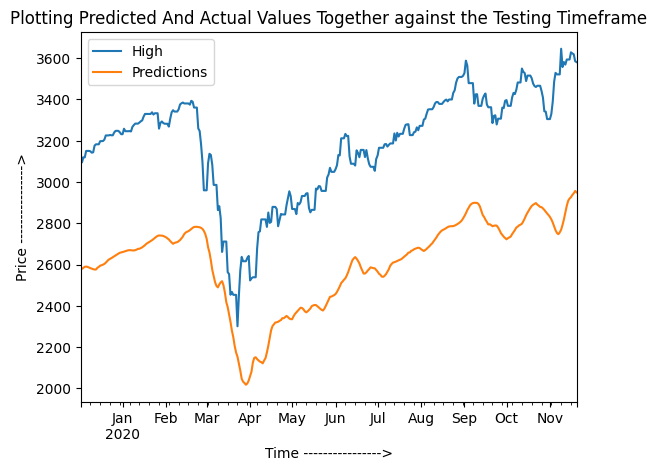

In [373]:
test = new_df.iloc[train_size+10:].copy()

test["Predictions"] = ypred
test[["High", "Predictions"]].plot()
plt.xlabel("Time ---------------->")
plt.ylabel("Price ---------------->")
plt.title("Plotting Predicted And Actual Values Together against the Testing Timeframe")

**ARIMA Model**

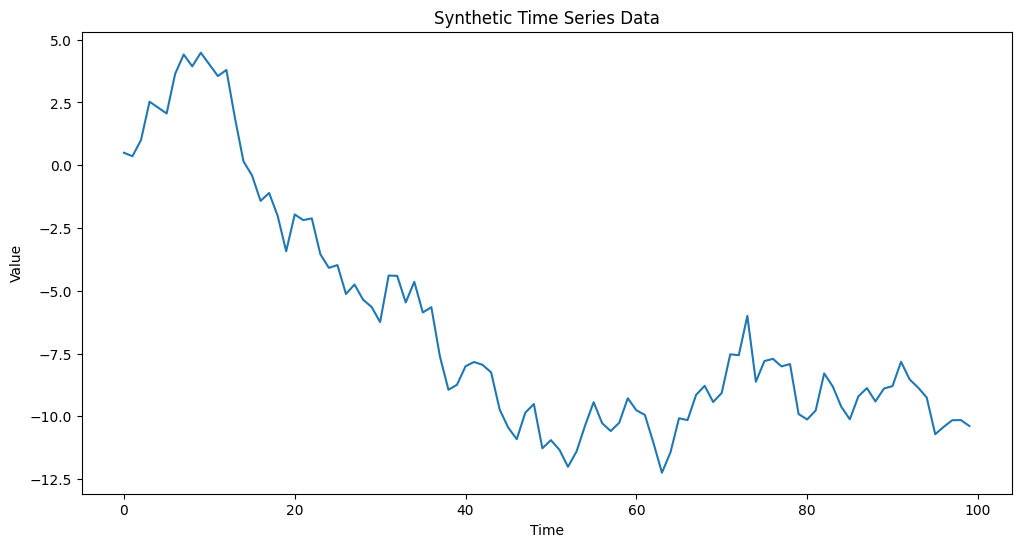

In [374]:
np.random.seed(42)
data = np.cumsum(np.random.randn(100))
ts = pd.Series(data)
plt.figure(figsize=(12, 6))
plt.plot(ts)
plt.title('Synthetic Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -131.425
Date:                Fri, 15 Sep 2023   AIC                            268.850
Time:                        12:02:55   BIC                            276.635
Sample:                             0   HQIC                           272.000
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3997      5.647      0.071      0.944     -10.669      11.468
ma.L1         -0.4158      5.590     -0.074      0.941     -11.371      10.540
sigma2         0.8329      0.123      6.780      0.0

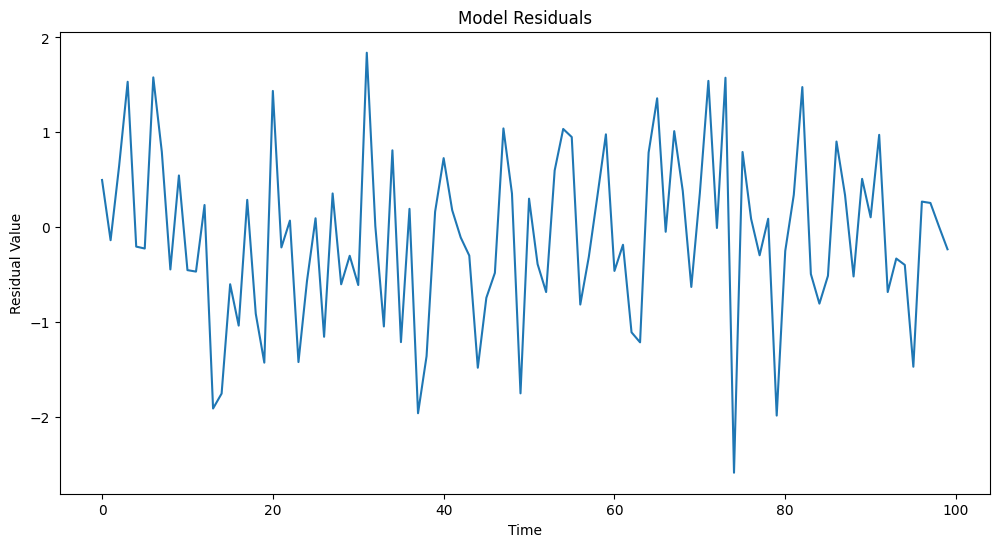

In [375]:
from statsmodels.tsa.arima.model import ARIMA
order = (1, 1, 1)  # ARIMA(p, d, q) order
model = ARIMA(ts, order=order)
model_fit = model.fit()
print(model_fit.summary())

# Plot model residuals
residuals = pd.Series(model_fit.resid)
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Model Residuals')
plt.xlabel('Time')
plt.ylabel('Residual Value')
plt.show()

# Make predictions
n_forecast = 10  # Number of future time steps to forecast
forecast = model_fit.forecast(steps=n_forecast)

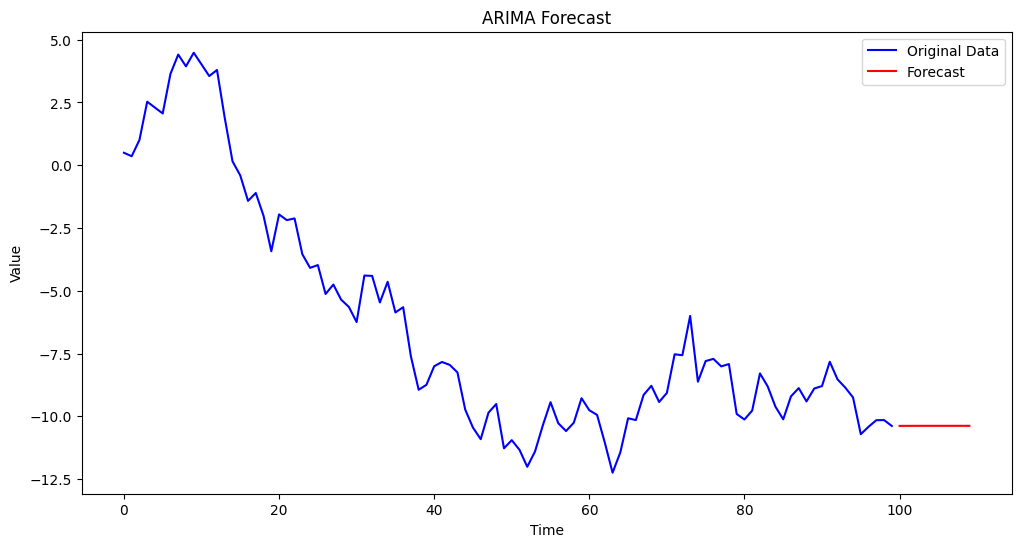

In [376]:
# Plot the original data and the forecasted values
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Original Data', color='blue')
plt.plot(range(len(ts), len(ts) + n_forecast), forecast, label='Forecast', color='red')
plt.title('ARIMA Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [377]:
# Calculate predictions using ARIMA
arima_preds = model_fit.fittedvalues

# The first value of the ARIMA predictions is NaN, so we'll ignore that
y_true = ts[1:]
y_pred = arima_preds[1:]

# Calculate MSE and RMSE for ARIMA
mse_arima = mean_squared_error(y_true, y_pred)
rmse_arima = mean_squared_error(y_true, y_pred, squared=False)

print(f"MSE for ARIMA Model: {mse_arima}")
print(f"RMSE for ARIMA Model: {rmse_arima}")

MSE for ARIMA Model: 0.8329095028117403
RMSE for ARIMA Model: 0.9126387581139321


**SMA Model**

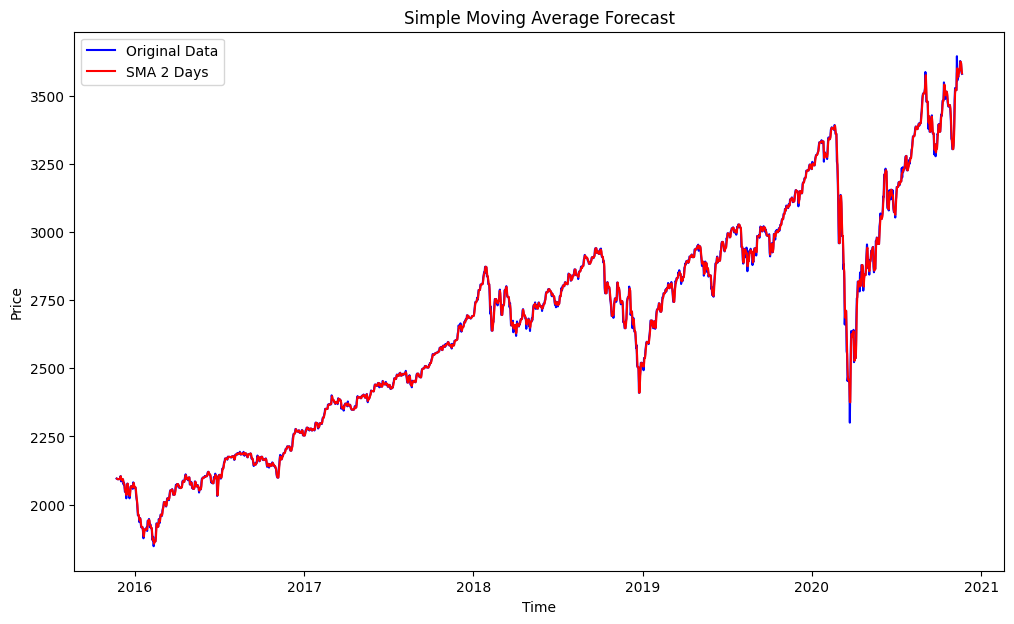

Best Window Size: 2
SMA MSE: 107.96856647895714
SMA RMSE: 10.390792389368443


In [378]:
# Calculate SMA for a range of window sizes
window_sizes = list(range(2, len(dataframe) // 2))  # considering up to half the dataset length
best_rmse = float('inf')
best_window_size = None

for window_size in window_sizes:
    sma = dataframe["High"].rolling(window=window_size).mean()

    # Calculate MSE and RMSE
    sma_values = sma[window_size-1:]
    actual_values = dataframe["High"][window_size-1:]
    mse = mean_squared_error(actual_values, sma_values)
    rmse = np.sqrt(mse)

    # Check for best RMSE
    if rmse < best_rmse:
        best_rmse = rmse
        best_window_size = window_size

# Plotting SMA predictions for best window size
sma_best = dataframe["High"].rolling(window=best_window_size).mean()
plt.figure(figsize=(12, 7))
plt.plot(dataframe["High"], label='Original Data', color='blue')
plt.plot(sma_best, label=f'SMA {best_window_size} Days', color='red')
plt.title('Simple Moving Average Forecast')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc="upper left")
plt.show()

print(f"Best Window Size: {best_window_size}")
print(f"SMA MSE: {mean_squared_error(dataframe['High'][best_window_size-1:], sma_best[best_window_size-1:])}")
print(f"SMA RMSE: {best_rmse}")

In [379]:
import plotly.graph_objs as go
import plotly.subplots as sp

# Create subplots
fig = sp.make_subplots(rows=2, cols=2, subplot_titles=("LSTM Model", "Bidirectional LSTM Model", "ARIMA Model", "SMA Model"))

# LSTM Model
trace_lstm = go.Scatter(x=np.arange(len(xtrain), len(xtrain) + len(xtest)), y=ypred.flatten(), mode='lines', name='LSTM Predictions', line=dict(color='red'))
trace_actual_lstm = go.Scatter(x=np.arange(len(xtrain), len(xtrain) + len(xtest)), y=ytest.flatten(), mode='lines', name='Actual', line=dict(color='blue'))

# Bidirectional LSTM Model
trace_bidirectional_lstm = go.Scatter(x=np.arange(len(xtrain), len(xtrain) + len(xtest)), y=ypred.flatten(), mode='lines', name='Bidirectional LSTM Predictions', line=dict(color='green'))

# ARIMA Model
trace_arima = go.Scatter(x=np.arange(len(ts), len(ts) + n_forecast), y=forecast, mode='lines', name='ARIMA Forecast', line=dict(color='purple'))

# SMA Model
trace_sma = go.Scatter(x=dataframe.index[best_window_size-1:], y=sma_best, mode='lines', name=f'SMA {best_window_size} Days', line=dict(color='orange'))
trace_actual_sma = go.Scatter(x=dataframe.index[best_window_size-1:], y=dataframe["High"][best_window_size-1:], mode='lines', name='Actual', line=dict(color='blue'))

# Add traces to subplots
fig.add_trace(trace_lstm, row=1, col=1)
fig.add_trace(trace_actual_lstm, row=1, col=1)
fig.add_trace(trace_bidirectional_lstm, row=1, col=2)
fig.add_trace(trace_arima, row=2, col=1)
fig.add_trace(trace_sma, row=2, col=2)
fig.add_trace(trace_actual_sma, row=2, col=2)

# Update layout
fig.update_layout(
    title='Comparison of Time Series Models',
    xaxis=dict(title='Time'),
    yaxis=dict(title='Price'),
)

# Show the plot
fig.show()
